This post aims to show how to construct the receiver operating characteristic (roc) curve without using predefined functions. It hopes to help you better understand how the roc curve is constructed and how to interpret it.

## Setup

In [1]:
#| include: false
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    in_colab = True
except Exception:
    in_colab = False

if in_colab:
    !pip install watermark

In [2]:
#| code-fold: show
%matplotlib inline

from typing import Tuple, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

## Load Data and Train Model

The dataset we will use for this blog is the famous Titanic dataset. For simplicity, we are going to use a subset of the data that does not contain missing values.

In [3]:
#| code-fold: show
data_path = "https://raw.githubusercontent.com/wpan03/quick_ds_python/master/data/titanic_train.csv"
sample_size = 200
seed = 36

In [4]:
#| code-fold: show
df_titanic = (pd.read_csv(data_path)
                .dropna(subset=['Age'])
                .sample(sample_size, random_state=seed)
                .reset_index(drop=True)
             )

This is the first 5 rows of the dataset.


In [5]:
df_titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,690,1,1,"Madill, Miss. Georgette Alexandra",female,15.0,0,1,24160,211.3375,B5,S
1,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0000,NaN,S
2,52,0,3,"Nosworthy, Mr. Richard Cater",male,21.0,0,0,A/4. 39886,7.8000,NaN,S
3,516,0,1,"Walker, Mr. William Anderson",male,47.0,0,0,36967,34.0208,D46,S
4,666,0,2,"Hickman, Mr. Lewis",male,32.0,2,0,S.O.C. 14879,73.5000,NaN,S


We train a simple logistic regression model by using only two columns as the independent variables - `Fare` and `Age` and try to predict whether a passenger can survive in the accident.


In [6]:
x_data = df_titanic[["Fare", "Age"]]
y = df_titanic["Survived"]
x_train, x_test, y_train, y_test = train_test_split(
    x_data, y, test_size=0.2, random_state=seed
)

In [7]:
mod_lg = LogisticRegression(random_state=seed).fit(x_train, y_train)

## Get ROC Curve

With the model setup, we can go into the core steps for constructing the roc curve. Constructing the roc curve includes 4 steps (this is adapted from lecture notes from Professor Spenkuch's business analytics class).

1. Sort predicted probability of "positive" outcome for each observation.
2. For each observation, record false positive rate (fpr) and true positive rate (tpr) if that observation's predicted probability were used as classification threshold.
3. Plot recorded pairs of tpr and fpr.
4. Connect the dots.

Let's show how to do those step by step.

First, we can get the sorted probability of positive outcomes (`prediction == 1`) of the next two lines of code.

In [8]:
y_pred_proba = mod_lg.predict_proba(x_test)[:, 1]
y_pred_proba_asc = np.sort(y_pred_proba)

Second, we define a function to calculate the fpr and tpr for a given threshold.

In [9]:
def get_tpr_fpr_pair(
    y_proba: np.ndarray, y_true: Union[np.ndarray, pd.Series], threshold: float
) -> Tuple[float, float]:
    """Get the true positive rate and false positive rate based on a certain threshold"""
    y_pred = (y_proba >= threshold).astype(int)
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    return tpr, fpr

With the function defined above, we can loop through each element in the sorted probability of positive outcomes and use each element as the threshold for our `get_tpr_fpr_pair` function and store the result in two lists.

In [10]:
tpr_list = []
fpr_list = []
for t in y_pred_proba_asc:
    tpr, fpr = get_tpr_fpr_pair(y_pred_proba, y_test, threshold=t)
    tpr_list.append(tpr)
    fpr_list.append(fpr)

Finally, after we have the record for each pair of tpr and fpr, we can plot them to get the roc curve.

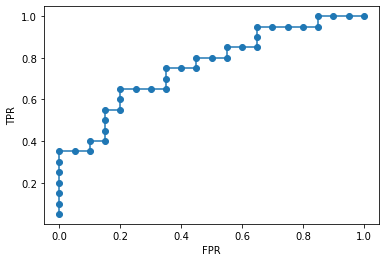

In [11]:
plt.scatter(fpr_list, tpr_list)
plt.plot(fpr_list, tpr_list)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

The following code shows what we construct from scratch is the same as what we get from the predefined functions in `scikit-learn`.

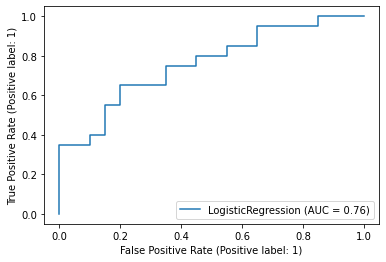

In [12]:
metrics.RocCurveDisplay.from_estimator(mod_lg, x_test, y_test)
plt.show()

That’s it for this blog post. To learn ROC and AUC from another perspective, you can check out this excellent video [here](https://www.youtube.com/watch?v=4jRBRDbJemM).

## Appendix

This appendix shows the Python and library version we used when writing this blog.

In [13]:
%load_ext watermark
%watermark --iversions

sys       : 3.8.8 (default, Feb 24 2021, 13:46:16) 
[Clang 10.0.0 ]
pandas    : 1.3.1
numpy     : 1.19.2
matplotlib: 3.3.2
sklearn   : 1.0

